Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

# Indices

In this tutorial, we demonstrate how to use TorchGeo's functions and transforms for computing popular indices used in remote sensing and provide examples of how to utilize them for analyzing raw imagery or simply for visualization purposes. Some common indices and their formulas can be found at the following links:

- [Index Database](https://www.indexdatabase.de/db/i.php)
- [Awesome Spectral Indices](https://github.com/davemlz/awesome-spectral-indices)

It's recommended to run this notebook on Google Colab if you don't have your own GPU. Click the "Open in Colab" button above to get started.

## Setup

Install TorchGeo

In [ ]:
%pip install torchgeo

## Imports

In [1]:
%matplotlib inline
import os
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import pyproj
import rasterio
import rasterio.features
import shapely
import torch

from torchgeo.datasets.utils import download_url
from torchgeo.transforms import indices

## Computing indices on raw Sentinel-2 imagery

In this section, we will be downloading [L2A processed Sentinel-2 imagery](https://docs.sentinel-hub.com/api/latest/data/sentinel-2-l2a/) over a region of interest. We will be downloading [Cloud Optimized GeoTIFF (COGs)](https://www.cogeo.org/) which allows us to extract and download a window/subset of a larger tile image hosted in the cloud without the need to download the entire image locally. Lastly, we will analyze the imagery by computing and visualizing various indices.

Below are some helper functions which perform the following:
- `extract_window`: The COG magic happens here. We take a predefined polygon geometry of lat/lon coordinates over a region of interest created on [geojson.io](https://geojson.io/), perform some transformations on the coordinates to convert them to the same [coordinate reference system (CRS)](https://geopandas.org/docs/user_guide/projections.html) as the image, convert the coordinates to a pixel coordinate bounding box, and finally extract the window and write to a new GeoTIFF.
- `download`: Sentinel-2 imagery is stored with separate GeoTIFFs per band. This function simply provides a loop over the separate files and downloads them using `extract_window`.
- `stack`: This function creates a new COG which combines the separate band files into a single .tif file which we then read into a stacked array.
- `normalize`: This function takes in an input array, computes min/max values per band/channel in the array, and normalizes the pixel values per band to the range [0, 1]. Optionally, a percentile value can be set to clip outliers, (e.g. percentile=98 clips outliers outside the range [2, 98] prior to normalizing). Using percentile clipping can be particularly important for visualization by creating a smoother color distribution prior to normalizing. 

In [2]:
def extract_window(path: str, url: str, geometry: shapely.geometry.Polygon) -> None:
    """Extract and write a subset of an image given a geometry and image url."""

    with rasterio.open(url) as ds:
        transform = pyproj.Transformer.from_crs("epsg:4326", ds.crs)
        # polygon to bbox (xyxy)
        bbox = rasterio.features.bounds(geometry)
        # convert bbox to source CRS (xyxy)
        coords = [
            transform.transform(bbox[3], bbox[0]),
            transform.transform(bbox[1], bbox[2]),
        ]
        # convert coords to pixel coords (xyxy)
        pcoords = [
            ds.index(coords[0][0], coords[0][1]),
            ds.index(coords[1][0], coords[1][1])
        ]
        # convert bbox (xyxy) -> (xxyy)
        bbox_xxyy = ((pcoords[0][0], pcoords[1][0]),
                     (pcoords[0][1], pcoords[1][1]))
        window = rasterio.windows.Window.from_slices(*bbox_xxyy)

        # Copy and update tiff metadata for windowed image
        metadata = ds.meta.copy()
        metadata.update(dict(
            height=window.height,
            width=window.width,
            transform=rasterio.windows.transform(window, ds.transform),
            compress="DEFLATE"
        ))

        # Write to geotiff
        with rasterio.open(path, "w", **metadata) as ds_windowed:
            ds_windowed.write(ds.read(1, window=window), 1)


def download(root: str, url: str, bands: List[str], geometry: shapely.geometry.Polygon) -> None:
    """Extract windows from each band COG file in s3 and save locally."""
    os.makedirs(root, exist_ok=True)
    for band in bands:
        file_url = os.path.join(url, band)
        file_path = os.path.join(root, band)
        extract_window(file_path, file_url, geometry)


def stack(root: str, bands: List[str]) -> None:
    """Stack separate band files to a single RGBNS image in EPSG:4326 CRS."""
    files = [os.path.join(root, band) for band in bands]
    with rasterio.open(files[0]) as ds:
        metadata = ds.meta
        metadata["count"] = len(files)
    
    with rasterio.open(f"{root}.tif", "w", **metadata) as dst:
        for i, f in enumerate(files, start=1):
            with rasterio.open(f) as src:
                dst.write_band(i, src.read(1))


def normalize(x: np.ndarray, percentile: int = 100) -> np.ndarray:
    """Min/max normalize to [0, 1] range given a percentile."""
    c, h, w = x.shape
    x = x.reshape(c, -1)
    min = np.percentile(x, 100 - percentile, axis=-1)[:, None, None]
    max = np.percentile(x, percentile, axis=-1)[:, None, None]
    x = x.reshape(c, h, w)
    x = np.clip(x, min, max)
    return (x - min) / (max - min)

## Downloading the Imagery

Here we download 2 multispectral (RGB, NIR, SWIR) Sentinel-2 images (dates: 11/16/2018 and 09/11/2021) over a region in the Texas Hill Country, west of Austin. Click [here](https://geojson.io/#map=12/30.4274/-98.3709) for an OpenStreetMap view.

In [3]:
geometry = shapely.geometry.Polygon([
    [-98.53225708007812, 30.274486436999464],
    [-98.20953369140625, 30.274486436999464],
    [-98.20953369140625, 30.57999697131928],
    [-98.53225708007812, 30.57999697131928],
    [-98.53225708007812, 30.274486436999464]
])
urls = [
    "https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/R/NU/2021/9/S2B_14RNU_20210911_0_L2A",
    "https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/R/NU/2018/11/S2B_14RNU_20181116_0_L2A",
]
roots = [url.split(os.sep)[-1] for url in urls]
bands = ["B04.tif", "B03.tif", "B02.tif", "B08.tif", "B11.tif"]

for url, root in zip(urls, roots):
    download(root, url, bands, geometry)
    stack(root, bands)

Listing the directories, we can see the separate band GeoTIFFs (B01.tif, B02.tif, ...) which were extracted from the COGs, as well as the combined GeoTIFFs ("S2B_14RNU_20181116_0_L2A.tif" and "S2B_14RNU_20210911_0_L2A.tif").

In [5]:
os.listdir()

['S2B_14RNU_20181116_0_L2A',
 'S2B_14RNU_20210911_0_L2A',
 'indices.ipynb',
 'transforms.ipynb',
 'custom_raster_dataset.ipynb',
 'trainers.ipynb',
 'S2B_14RNU_20210911_0_L2A.tif',
 '.ipynb_checkpoints',
 'S2B_14RNU_20181116_0_L2A.tif',
 'benchmarking.ipynb',
 'getting_started.ipynb']

## Read the images

Below we use `rasterio` to read the images in numpy arrays as well as printing some information about the images (image shape, number of bands, crs).

In [12]:
ds1 = rasterio.open("S2B_14RNU_20181116_0_L2A.tif")
ds2 = rasterio.open("S2B_14RNU_20210911_0_L2A.tif")
print(ds1.shape, ds2.shape)
print(ds1.count, ds2.count)
print(ds1.crs, ds2.crs)

x1 = ds1.read()
x2 = ds2.read()

print(x1.shape)
print(x2.shape)

ds1.close()
ds2.close()

(3368, 3118) (3368, 3118)
5 5
EPSG:32614 EPSG:32614
(5, 3368, 3118)
(5, 3368, 3118)


## Normalize and convert to torch Tensors

Here we normalize the image bands to [0, 1] and convert from numpy arrays to torch tensors.

In [13]:
x1 = normalize(x1, percentile=99.9).astype(np.float32)
x2 = normalize(x2, percentile=99.9).astype(np.float32)
x1, x2 = torch.from_numpy(x1), torch.from_numpy(x2)
sample1, sample2 = {"image": x1}, {"image": x2}


## Plot RGB True Color Images

We can plot a true color image consisting of the first 3 channels (RGB) to visualize the region.

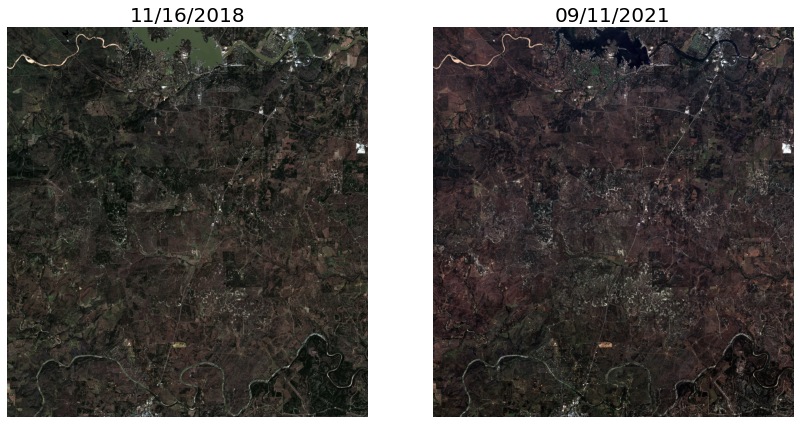

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.imshow(sample1["image"][:3].permute(1, 2, 0))
ax1.set_axis_off()
ax1.set_title("11/16/2018", fontsize=20)
ax2.imshow(sample2["image"][:3].permute(1, 2, 0))
ax2.set_axis_off()
ax2.set_title("09/11/2021", fontsize=20)
plt.tight_layout()
plt.show()
plt.close()

## Normalized Difference Vegetation Index (NDVI)

Below we use TorchGeo's `indices.AppendNDVI` to compute the [Normalized Difference Vegetation Index (NDVI)](https://gisgeography.com/ndvi-normalized-difference-vegetation-index/) from ["Red and photographic infrared linear combinations for monitoring vegetation", Tucker et al. (1979)](https://doi.org/10.1016/0034-4257(79)90013-0). NDVI is useful for measuring the presence of vegetation and vegetation health. It can be calculated using the Red and Near Infrared (NIR) bands using the formula below, resulting in a value between [-1, 1] where low NDVI values represents no or unhealthy vegetation and high NDVI values represents healthy vegetation. Here we use a diverging red, yellow, green colormap representing -1, 0, and 1, respectively.

`NDVI = (Red - NIR) / (Red + NIR)`

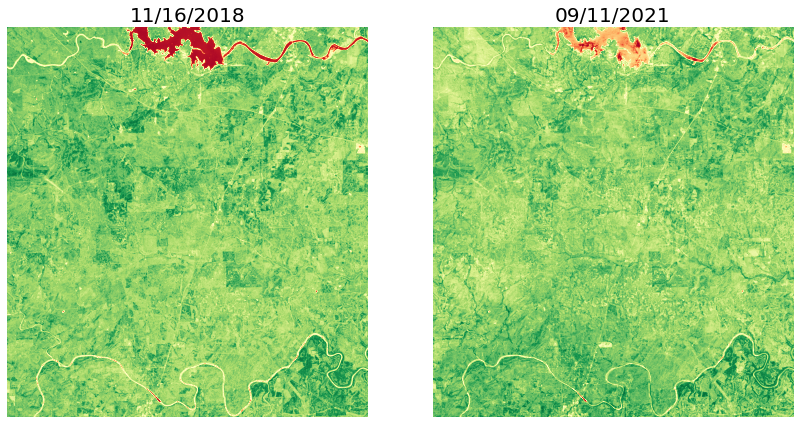

In [15]:
# NDVI is appended to channel dimension (dim=0)
index = indices.AppendNDVI(index_red=0, index_nir=3)
sample1 = index(sample1)
sample2 = index(sample2)

# Normalize from [-1, 1] -> [0, 1] for visualization
sample1["image"][-1] = (sample1["image"][-1] + 1) / 2
sample2["image"][-1] = (sample2["image"][-1] + 1) / 2

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.imshow(sample1["image"][-1], cmap="RdYlGn_r")
ax1.set_axis_off()
ax1.set_title("11/16/2018", fontsize=20)
ax2.imshow(sample2["image"][-1], cmap="RdYlGn_r")
ax2.set_axis_off()
ax2.set_title("09/11/2021", fontsize=20)
plt.tight_layout()
plt.show()
plt.close()

## Normalized Difference Water Index (NDWI)

Below we use TorchGeo's `indices.AppendNDWI` to compute the [Normalized Difference Water Index (NDWI)](https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/ndwi/) from ["The use of the Normalized Difference Water Index (NDWI) in the delineation of open water features", McFeeters et al. (1995)](https://doi.org/10.1080/01431169608948714). NDWI is useful for measuring the presence of water content in water bodies. It can be calculated using the Green and Near Infrared (NIR) bands using the formula below, resulting in a value between [-1, 1] where low NDWI values represents no water and high NDWI values represents water bodies. Here we use a diverging brown, white, blue-green colormap representing -1, 0, and 1, respectively.

`NDWI = (Green - NIR) / (Green + NIR)`

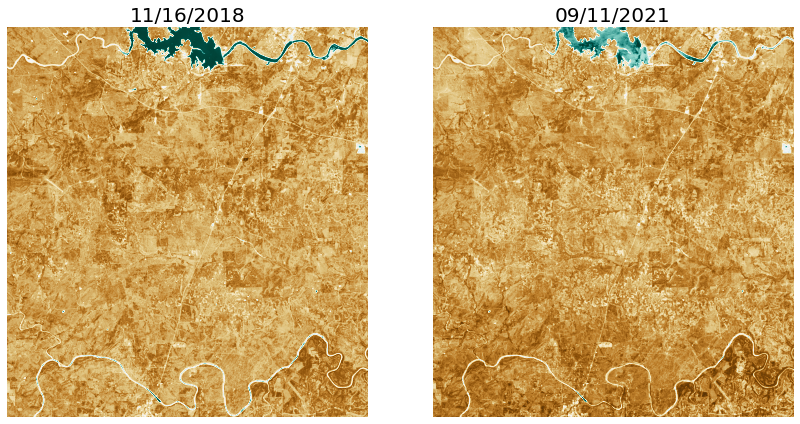

In [16]:
# NDWI is appended to channel dimension (dim=0)
index = indices.AppendNDWI(index_green=1, index_nir=3)
sample1 = index(sample1)
sample2 = index(sample2)

# Normalize from [-1, 1] -> [0, 1] for visualization
sample1["image"][-1] = (sample1["image"][-1] + 1) / 2
sample2["image"][-1] = (sample2["image"][-1] + 1) / 2

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.imshow(sample1["image"][-1], cmap="BrBG")
ax1.set_axis_off()
ax1.set_title("11/16/2018", fontsize=20)
ax2.imshow(sample2["image"][-1], cmap="BrBG")
ax2.set_axis_off()
ax2.set_title("09/11/2021", fontsize=20)
plt.tight_layout()
plt.show()
plt.close()

## Normalized Difference Built-up Index (NDBI)

Below we use TorchGeo's `indices.AppendNDBI` to compute the [Normalized Difference Built-up Index (NDBI)](https://www.linkedin.com/pulse/ndvi-ndbi-ndwi-calculation-using-landsat-7-8-tek-bahadur-kshetri/) from ["Use of normalized difference built-up index in automatically mapping urban areas from TM imagery", Zha et al. (2010)](https://doi.org/10.1080/01431160304987). NDBI is useful for measuring the presence of urban buildings. It can be calculated using the Short-wave Infrared (SWIR)  and Near Infrared (NIR) bands using the formula below, resulting in a value between [-1, 1] where low NDBI values represents no urban land and high NDBI values represents urban land. Here we use a terrain colormap with blue, green-yellow, and brown representing -1, 0, and 1, respectively.

`NDBI = (SWIR - NIR) / (SWIR + NIR)`

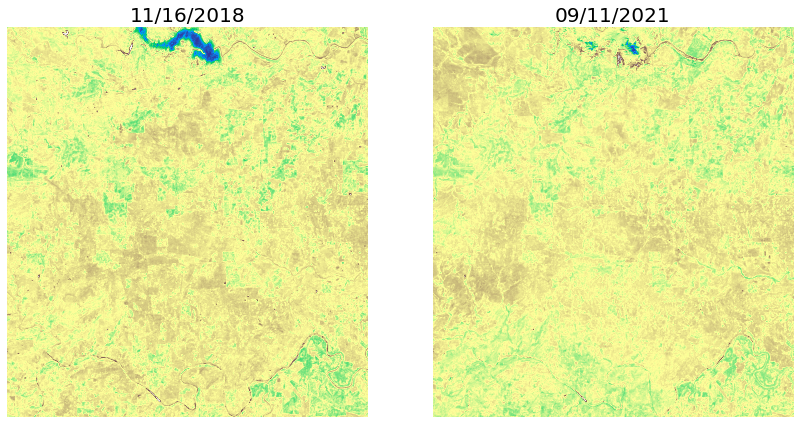

In [18]:
# NDBI is appended to channel dimension (dim=0)
index = indices.AppendNDBI(index_swir=4, index_nir=3)
sample1 = index(sample1)
sample2 = index(sample2)

# Normalize from [-1, 1] -> [0, 1] for visualization
sample1["image"][-1] = (sample1["image"][-1] + 1) / 2
sample2["image"][-1] = (sample2["image"][-1] + 1) / 2

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.imshow(sample1["image"][-1], cmap="terrain")
ax1.set_axis_off()
ax1.set_title("11/16/2018", fontsize=20)
ax2.imshow(sample2["image"][-1], cmap="terrain")
ax2.set_axis_off()
ax2.set_title("09/11/2021", fontsize=20)
plt.tight_layout()
plt.show()
plt.close()